## Test Analysis

In [ ]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from glob import glob
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from datetime import datetime
from IPython import get_ipython
from IPython.display import display, Markdown

ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

os.chdir(ROOT)

### 1) Generate synthetic data

In this section we will create a suite of synthetic insurance‐policy datasets. We generate four different *scenario types* at three *scales*, for a total of 6 × 2 = 12 CSVs:

1. **Low-density, single city** (`low_1zone`):  
   – 1 000 / 100 000 policies  
   – All points randomly distributed within Madrid’s bounding box  
   – No “high-value” policies (all insured sums drawn uniformly from 1 000#–100 000€)

2. **Low-density, three cities** (`low_3zones`):  
   – 1 000 / 100 000 policies  
   – Points split evenly (plus leftovers) across Madrid, Valencia, Barcelona  
   – No “high-value” policies (all insured sums drawn uniformly from 1 000#–100 000€)

3. **High-density, single city** (`high_1zone`):  
   – 1 000 / 100 000 policies  
   – Madrid only  
   – 10 % of policies “high-value” (500 000€–2 500 000€), rest 1 000€–100 000€

4. **High-density, three cities** (`high_3zones`):  
   – 1 000 / 100 000 policies  
   – Madrid + Valencia + Barcelona  
   – 10 % of policies “high-value” (500 000€–2 500 000€), rest 1 000€–100 000€

5. **Whole-Spain low** (`spain_low`):  
   – 1 000 / 100 000 policies  
   – Uniformly sampled *within* Spain’s true borders (mainland + islands)  
   – No “high-value” policies (all insured sums drawn uniformly from 1 000#–100 000€)

6. **Whole-Spain high** (`spain_high`):  
   – 1 000 / 10 000 / 100 000 policies  
   – Full-Spain geography  
   – 10 % of policies “high-value” (500 000€–2 500 000€), rest 1 000€–100 000€

Each run writes out a file named: policies_{N}_{scenario}.csv into the `data/` folder, where `{N}` is one of 1000 or 100000, and `{scenario}` is one of the six labels above. 

We fix `seed=42` for reproducibility, so the exact same points and insured sums will be generated each time.



In [2]:
from modules.generate_synthetic_data import (
    generate_synthetic_policies,
    generate_synthetic_spanish_policies
)

DATA_DIR = os.path.join(ROOT, "data")

# Sizes to generate
sizes = [1_000, 100_000]

# Define (label, generator_func, extra_kwargs) tuples
scenarios = [
    ("low_1zone",   generate_synthetic_policies,        {"zones": ["madrid"],                       "high_value_ratio": 0.00}),
    ("low_3zones",  generate_synthetic_policies,        {"zones": ["madrid","valencia","barcelona"],"high_value_ratio": 0.00}),
    ("high_1zone",  generate_synthetic_policies,        {"zones": ["madrid"],                       "high_value_ratio": 0.10}),
    ("high_3zones", generate_synthetic_policies,        {"zones": ["madrid","valencia","barcelona"],"high_value_ratio": 0.10}),
    ("spain_low",   generate_synthetic_spanish_policies,{"high_value_ratio": 0.00}),
    ("spain_high",  generate_synthetic_spanish_policies,{"high_value_ratio": 0.10}),
]

# Single pass through every combination of scenario and size
for label, gen_func, extra in scenarios:
    for n in sizes:
        fname = f"policies_{n}_{label}.csv"
        out   = os.path.join(DATA_DIR, fname)
        gen_func(
            output_path  = out,
            n_policies   = n,
            seed         = 1,
            **extra
        )

print("Data generated at",  datetime.now().isoformat())
print("\n✅ All datasets saved under /data")

Data generated at 2025-05-03T19:36:52.034659

✅ All datasets saved under /data


### 2) Overview of “insured_sum” and spatial distribution

In this section we’ll take all 12 of our generated `policies_*.csv` files and:

1. **Discover & load** each CSV in `data/`  
   We use Python’s `os.listdir` to find all `policies_*.csv` and read them into Pandas DataFrames.

2. **Compute descriptive statistics** on the `insured_sum` column  
   For each DataFrame we call `.describe()`, which gives us:
   - **count** → Total number of policies  
   - **min**   → Smallest sum  
   - **25%**   → 1st quartile  
   - **50%**   → Median  
   - **75%**   → 3rd quartile  
   - **mean**  → Average  
   - **max**   → Largest sum  
   - **std**   → Standard deviation  

   We collect these into a single “global KPI” table so we can immediately compare:
   - **Scale effects**: 1 000 vs. 100 000 policies  
   - **Value effects**: “low” vs. “high” share of big sums  
   - **Geography effects**: city‐zones vs. whole‐Spain  
   - **Outliers**: do any scenarios produce unexpected extremes?

3. **Assemble** the per‐file stats into one summary DataFrame  
   Indexing by `dataset`, we get a clear side-by-side view of all eight statistics for each scenario/size.

4. **Visualize** each portfolio’s spatial footprint as small-multiples  
   - Layout: a **3×4 grid** of scatter plots  
   - Axes: Longitude (X) vs. Latitude (Y)  
   - **Color**: maps raw `insured_sum` onto a common Viridis scale (0 → global max)  
   - **Size**: marker area ∝ √(`insured_sum`) (so that very large sums remain visible but not overwhelming)  
   - Shared colorbar formatted in “million €” (e.g. `2.5 M€`)  

By combining these two views—the numeric KPIs and the point clouds—we get both a **quantitative benchmark** and a **geospatial sense** of how each synthetic portfolio is distributed and where its exposures concentrate.  


In [3]:
# 1) Grab all CSVs in that folder
csv_files = [
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR)
    if f.endswith(".csv")
]

records = []
for fullpath in csv_files:
    name = os.path.basename(fullpath)
    df   = pd.read_csv(fullpath)

    # 2) Compute .describe() on insured_sum
    desc = df["insured_sum"].describe()

    # 3) Build our KPI-record
    rec = {
        "dataset":           name,
        "Total Policies":    int(desc["count"]),
        "Minimum (€)":       desc["min"],
        "1st Quartile (€)":  desc["25%"],
        "Median (€)":        desc["50%"],
        "3rd Quartile (€)":  desc["75%"],
        "Mean (€)":          desc["mean"],
        "Maximum (€)":       desc["max"],
        "St.Dev. (€)":       desc["std"],
    }
    records.append(rec)

# 4) Only proceed if we actually collected anything
if not records:
    raise RuntimeError(f"No records collected—check DATA_DIR={DATA_DIR}")

# 5) Build DataFrame
kpi_df = pd.DataFrame.from_records(records)
# We know "dataset" is in there now:
kpi_df.set_index("dataset", inplace=True)

# 6) Display with Spanish formatting
kpi_df.style.format("{:,.2f}")

,Total Policies,Minimum (€),1st Quartile (€),Median (€),3rd Quartile (€),Mean (€),Maximum (€),St.Dev. (€)
dataset,,,,,,,,
policies_100000_high_1zone.csv,"100,000.00","1,002.00","28,622.00","55,846.00","83,374.00","194,392.74","2,499,943.00","469,492.21"
policies_100000_high_3zones.csv,"100,000.00","1,003.00","28,517.00","55,590.00","83,329.00","196,350.98","2,499,510.00","474,757.41"
policies_100000_low_1zone.csv,"100,000.00","1,001.00","25,860.50","50,454.50","75,155.25","50,466.33","99,999.00","28,521.05"
policies_100000_low_3zones.csv,"100,000.00","1,003.00","25,838.00","50,295.00","74,923.00","50,414.48","99,997.00","28,484.85"
policies_100000_spain_high.csv,"100,000.00","1,002.00","28,622.00","55,846.00","83,374.00","194,392.74","2,499,943.00","469,492.21"
policies_100000_spain_low.csv,"100,000.00","1,001.00","25,860.50","50,454.50","75,155.25","50,466.33","99,999.00","28,521.05"
policies_1000_high_1zone.csv,"1,000.00","1,092.00","27,478.50","54,031.00","80,829.25","188,355.93","2,487,448.00","455,970.16"
policies_1000_high_3zones.csv,"1,000.00","1,092.00","27,297.00","50,882.00","79,321.00","179,043.17","2,460,169.00","426,870.41"
policies_1000_low_1zone.csv,"1,000.00","1,092.00","24,820.75","48,586.00","71,828.25","48,915.12","99,997.00","27,558.84"


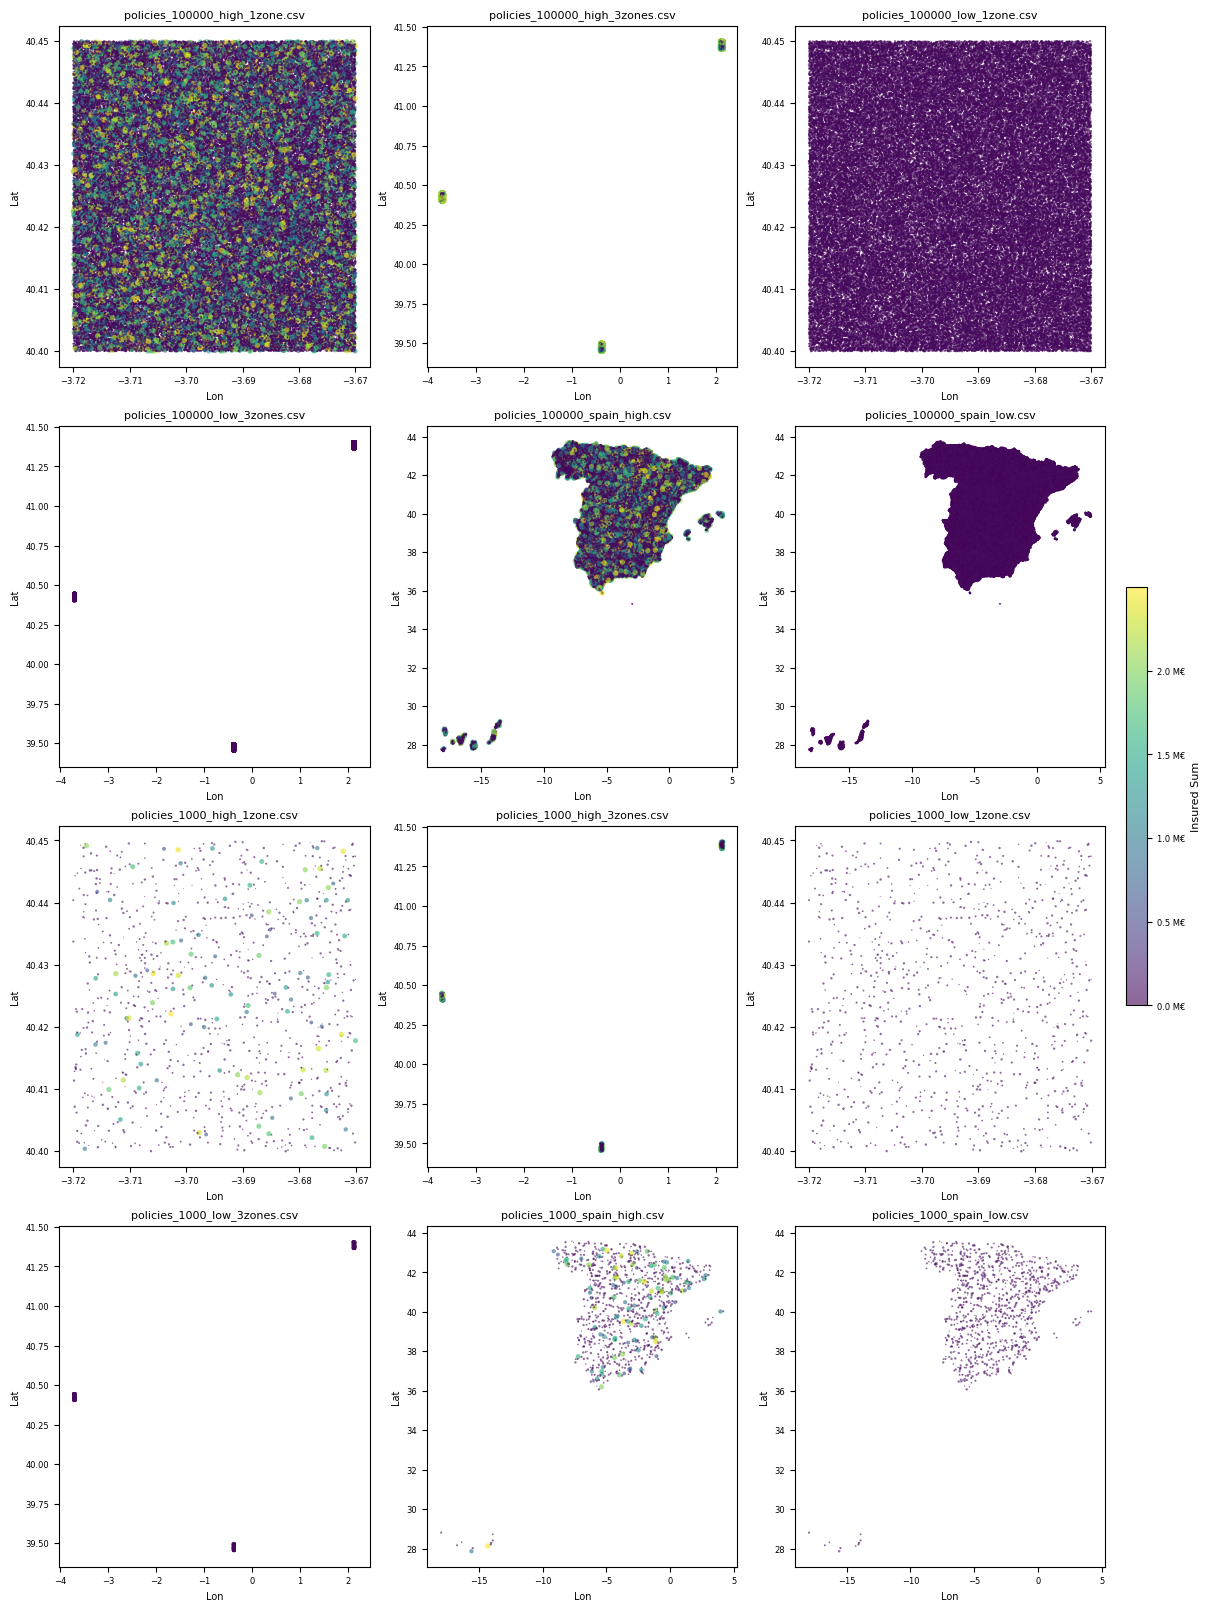

In [4]:
cols, rows = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4), 
                         sharex=False, sharey=False, constrained_layout=True)

all_max = 0
for fname in csv_files:
    df = pd.read_csv(os.path.join(DATA_DIR, fname))
    all_max = max(all_max, df["insured_sum"].max())

# Format milions
def millions(x, pos):
    return f"{x*1e-6:,.1f} M€"
fmt = FuncFormatter(millions)

# Draw panels
for ax, fullpath in zip(axes.flat, csv_files):
    name = os.path.basename(fullpath)
    df   = pd.read_csv(fullpath)
    sizes = np.sqrt(df["insured_sum"]) * 0.01
    sc    = ax.scatter(
        df["lon"], df["lat"],
        c=df["insured_sum"],
        cmap="viridis",
        vmin=0, vmax=all_max,
        s=sizes,
        alpha=0.6,
        linewidth=0,
    )

    ax.set_title(name, fontsize=8)
    ax.set_xlabel("Lon", fontsize=7)
    ax.set_ylabel("Lat", fontsize=7)
    ax.tick_params(axis="both", labelsize=6)

cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation="vertical",
                    fraction=0.02, pad=0.02)
cbar.set_label("Insured Sum", fontsize=8)
cbar.ax.yaxis.set_major_formatter(fmt)
cbar.ax.tick_params(labelsize=6)

plt.show()

### 3) Automated Test‐Suite Execution & Report Generation

In this step we will automatically run each of the `test_*.py` scripts under our two test‐folders:

**tests/by_papers/**  
- `test_exhaustive.py`  
- `test_grid.py`  
- `test_metaheuristic.py`  

**tests/new_methods/**  
- `test_exhaustive_fast.py`  
- `test_fast_with_grid.py`  
- `fast_fast_with_multilocal.py`  

Each of these scripts invokes one of our six concentration‐risk functions (three “old” papers’ methods + three “new” methods), benchmarks it over our synthetic datasets, and writes out a `.csv` report into the `tests/results` folder.

**What we’ll do:**

1. **Discover** all `test_*.py` scripts under `tests/`.  
2. **Execute** each one 5 times via a subprocess, capturing any failures.  
3. **Leave** each last test’s CSV output in place under `tests/results`, ready for later analysis or dashboarding.  

In [5]:
def run_experiments(script: str, out_csv: str, algorithm: str, runs: int = 5) -> pd.DataFrame:
    """
    Executes the benchmark script `runs` times, each time **overwriting**
    the same CSV file at `out_csv`. After each run:

      1. The script writes the full CSV.
      2. We read the newly generated CSV.
      3. We add 'algorithm' and 'run' columns to identify the execution.
      4. We store it in memory in a list of DataFrames.

    At the end, we concatenate all these DataFrames into one and return it,
    without keeping intermediate copies on disk.

    Parameters:
    - script    : path to the Python script that generates `out_csv`.
    - out_csv   : path to the CSV file that the script overwrites on each run.
    - algorithm : identifier name for the algorithm (e.g., "exhaustive").
    - runs      : number of repetitions to execute.

    Returns:
    - pd.DataFrame with `runs × N` rows, where N is the number of rows
      produced by the CSV in a single run.
    """
    all_runs = []
    for run in range(1, runs + 1):
        print(f"▶ Run {run}/{runs}  {algorithm} … ", end="", flush=True)
        # Executes the script, which internally does: pd.DataFrame(results).to_csv(out_csv)
        get_ipython().run_line_magic('run', f'-i {script}')
        print("OK", datetime.now().isoformat())

        # Read the newly generated output (same out_csv each time)
        df_run = pd.read_csv(out_csv)
        df_run['algorithm'] = algorithm
        df_run['run']       = run
        all_runs.append(df_run)

    # Concatenate into a single DataFrame and return
    return pd.concat(all_runs, ignore_index=True)


def summarize_runs(all_df: pd.DataFrame,
                   group_keys: list = ["algorithm", "distance_type", "dataset"]) -> pd.DataFrame:
    """
    Groups all_df by group_keys and computes:
     - sum_{max, min, mean}, time_{max, min, mean}, group_{max, min, mean}
     - lat/ lon/ run corresponding to sum_max
    """
    records = []
    grouped = all_df.groupby(group_keys, dropna=False)

    for key_vals, g in grouped:
        sums  = pd.to_numeric(g["sum_serial"],       errors="coerce")
        times = pd.to_numeric(g["time_serial_sec"],  errors="coerce")
        sizes = pd.to_numeric(g["group_size_serial"],errors="coerce")

        stats = {
            'sum_max':  sums.max(),
            'sum_min':  sums.min(),
            'sum_mean': sums.mean(),
            'time_max': times.max(),
            'time_min': times.min(),
            'time_mean':times.mean(),
            'group_max':sizes.max(),
            'group_min':sizes.min(),
            'group_mean':sizes.mean(),
        }

        # Coordinates and run of the best result (sum_max)
        if not sums.dropna().empty:
            idx_max = sums.idxmax()
            stats.update({
                'lat_center_max': g.at[idx_max, "lat_center"],
                'lon_center_max': g.at[idx_max, "lon_center"],
                'run_max':        g.at[idx_max, "run"]
            })
        else:
            stats.update({
                'lat_center_max': np.nan,
                'lon_center_max': np.nan,
                'run_max':        np.nan
            })

        # Build record: unpack key_vals if there are multiple group keys
        if isinstance(key_vals, tuple):
            for col, val in zip(group_keys, key_vals):
                stats[col] = val
        else:
            stats[group_keys[0]] = key_vals

        records.append(stats)

    return pd.DataFrame(records)

In [6]:
# 1- Exhaustive brute‐force (exhaustive_concentration)
SCRIPT       = "tests/by_papers/test_exhaustive.py"
OUT_CSV      = "tests/results/test_exhaustive_results.csv"
ALGORITHM    = "exhaustive"

# 1) Execute and recollect
exhaustive_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(exhaustive_df)} rows (runs × rows per CSV).")

# 2) Summary
exhaustive_summary = summarize_runs(exhaustive_df)

▶ Run 1/5  exhaustive … 🚀 Starting exhaustive_concentration benchmark...

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 Serial → HAVERSINE | Radius 200m
   ❌ Serial failed: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
🔎 Serial → EUCLIDEAN | Radius 200m
   ❌ Serial failed: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 Serial → HAVERSINE | Radius 200m
   ❌ Serial failed: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
🔎 Serial → EUCLIDEAN | Radius 200m
   ❌ Serial failed: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 Serial → HAVERSINE | Radius 200m
   ❌ Serial failed: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
🔎 Serial → EUCLI

In [7]:
# Grid‐search via spatialrisk (grid_search_r)
SCRIPT       = "tests/by_papers/test_grid.py"
OUT_CSV      = "tests/results/test_grid_results.csv"
ALGORITHM    = "grid"

# 1) Execute and recollect
grid_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(grid_df)} rows (runs × rows per CSV).")

# 2) Summary
grid_summary = summarize_runs(grid_df)

▶ Run 1/5  grid … 🚀 Starting grid_search_r (spatialrisk) benchmark…

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_100000_low_3zones.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_100000_spain_high.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_100000_spain_low.csv | 100000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_1000_high_1zone.csv | 1000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_1000_high_3zones.csv | 1000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_1000_low_1zone.csv | 1000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policies_1000_low_3zones.csv | 1000 policies
🔎 Grid → HAVERSINE | Radius 200m
📄 Dataset: policie

In [8]:
# Pattern‐search metaheuristic (multi_start_continuous_search)
SCRIPT       = "tests/by_papers/test_metaheuristic.py"
OUT_CSV      = "tests/results/test_metaheuristic_results.csv"
ALGORITHM    = "metaheuristic"

# 1) Execute and recollect
metaheuristic_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(metaheuristic_df)} rows (runs × rows per CSV).")

# 2) Summary
metaheuristic_summary = summarize_runs(metaheuristic_df)

▶ Run 1/5  metaheuristic … 🚀 Starting multi_start_continuous_search benchmark...

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_3zones.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_high.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_low.csv | 100000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_1000_high_1zone.csv | 1000 policies
🔎 multi_start_continuous_search → EUCLIDEAN | Radius 200m
📄 Dataset: policies_1000_high_3zones.csv | 1000 policies
🔎 multi_start_continuous_search → EUCLID

In [9]:
# Fast‐exhaustive via BallTree + sparse (fast_exhaustive)
SCRIPT       = "tests/new_methods/test_exhaustive_fast.py"
OUT_CSV      = "tests/results/test_exhaustive_fast_results.csv"
ALGORITHM    = "fast_exhaustive"

# 1) Execute and recollect
fast_exhaustive_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(fast_exhaustive_df)} rows (runs × rows per CSV).")

# 2) Summary
fast_exhaustive_summary = summarize_runs(fast_exhaustive_df)

▶ Run 1/5  fast_exhaustive … 🚀 Starting fast_exhaustive benchmark…

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_3zones.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_high.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_low.csv | 100000 policies
🔎 fast_exhaustive → HAVERSINE | Radius 200m
🔎 fast_exhaustive → EUCLIDEAN | Radius 200m
📄 Dataset: policies_1000_high_1zone.csv | 100

In [10]:
# Fast‐exhaustive with grid search (fast_with_grid)
SCRIPT       = "tests/new_methods/test_fast_with_grid.py"
OUT_CSV      = "tests/results/test_fast_with_grid_results.csv"
ALGORITHM    = "fast_with_grid"

# 1) Execute and recollect
fast_with_grid_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(fast_with_grid_df)} rows (runs × rows per CSV).")

# 2) Summary
fast_with_grid_summary = summarize_runs(fast_with_grid_df)

▶ Run 1/5  fast_with_grid … 🚀 Starting fast_plus_local_refine benchmark...

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fast_plus_local_refine → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fast_plus_local_refine → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fast_plus_local_refine → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_3zones.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fast_plus_local_refine → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_high.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fast_plus_local_refine → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_low.csv | 100000 policies
🔎 fast_plus_local_refine → HAVERSINE | Radius 200m
🔎 fa

In [11]:
# Fast‐exhaustive with multilocal search (fast_with_multilocal)
SCRIPT       = "tests/new_methods/test_fast_with_multilocal.py"
OUT_CSV      = "tests/results/test_fast_with_multilocal_results.csv"
ALGORITHM    = "fast_with_multilocal"

# 1) Execute and recollect
fast_with_multilocal_df = run_experiments(SCRIPT, OUT_CSV, ALGORITHM, runs=5)
print(f"\n✅ Collected {len(fast_with_multilocal_df)} rows (runs × rows per CSV).")

# 2) Summary
fast_with_multilocal_summary = summarize_runs(fast_with_multilocal_df)

▶ Run 1/5  fast_with_multilocal … 🚀 Starting fast_with_multilocal benchmark...

📄 Dataset: policies_100000_high_1zone.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_high_3zones.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_1zone.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_low_3zones.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_high.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal → EUCLIDEAN | Radius 200m
📄 Dataset: policies_100000_spain_low.csv | 100000 policies
🔎 fast_with_multilocal → HAVERSINE | Radius 200m
🔎 fast_with_multilocal

### 4) Per‐Dataset Algorithm Comparison (Including Distance/Metric)

In this final step we’ll assemble, for each of our 12 synthetic datasets, the results from all six methods—showing which distance or metric was used—and then compare:

1. **Discover** all `*_results.csv` files under `tests/results`.
2. **Extract** the algorithm name from each filename (e.g. `test_exhaustive_results.csv` → `exhaustive`).
3. **Normalize** key output columns:
   - `sum` → total insured‐sum found
   - `group_size` → number of policies in the circle
   - `time_sec` → runtime in seconds
5. **Concatenate** everything into one master DataFrame of raw results.
6. **Summarize** each algorithm’s performance per dataset (max/min/mean of sum, time, group size, plus the center & run of the best).  
6. Finally, **pivot** on `(dataset, distance_type)` × `algorithm` to compare at a glance:
   - A styled table of **average times** (bold-highlighting the fastest),  
   - A styled table of **average sums** (bold-highlighting the largest).


In [12]:
summaries = [
    ("exhaustive",                    exhaustive_summary),
    ("grid_search_r",                 grid_summary),
    ("multi_start_continuous_search", metaheuristic_summary),
    ("fast_exhaustive",               fast_exhaustive_summary),
    ("fast_with_grid",                fast_with_grid_summary),
    ("fast_with_multilocal",          fast_with_multilocal_summary),
]

for name, df in summaries:
    display(Markdown(f"### Summary — **{name}**"))
    display(df)

### Summary — **exhaustive**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_high_1zone.csv
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_high_3zones.csv
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_low_1zone.csv
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_low_3zones.csv
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_spain_high.csv
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exhaustive,euclidean,policies_100000_spain_low.csv
6,5082386.0,5082386.0,5082386.0,0.1253,0.1171,0.12022,11.0,11.0,11.0,40.42704759024811,-3.6756001753036767,1.0,exhaustive,euclidean,policies_1000_high_1zone.csv
7,5665365.0,5665365.0,5665365.0,0.1352,0.1122,0.12348,6.0,6.0,6.0,39.47224084358194,-0.3689078702885637,1.0,exhaustive,euclidean,policies_1000_high_3zones.csv
8,628052.0,628052.0,628052.0,0.1499,0.1197,0.12792,11.0,11.0,11.0,40.42805151096279,-3.70777760003142,1.0,exhaustive,euclidean,policies_1000_low_1zone.csv
9,467412.0,467412.0,467412.0,0.1290,0.1220,0.12438,7.0,7.0,7.0,39.458534276301705,-0.3899901828103913,1.0,exhaustive,euclidean,policies_1000_low_3zones.csv


### Summary — **grid_search_r**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,152274324.0,152274324.0,152274324.0,22.0739,21.2995,21.72390,543,543,543.0,40.431035,-3.689931,1,grid,haversine,policies_100000_high_1zone.csv
1,60785328.0,60785328.0,60785328.0,54.3708,52.4449,53.52412,194,194,194.0,39.495746,-0.391434,1,grid,haversine,policies_100000_high_3zones.csv
2,33016672.0,33016672.0,33016672.0,21.9696,21.4211,21.59092,617,617,617.0,40.419599,-3.680420,1,grid,haversine,policies_100000_low_1zone.csv
3,11765305.0,11765305.0,11765305.0,53.9733,53.4484,53.79320,230,230,230.0,40.406264,-3.713379,1,grid,haversine,policies_100000_low_3zones.csv
4,4557335.0,4557335.0,4557335.0,2.4352,1.9746,2.18714,2,2,2.0,41.617558,-2.781215,1,grid,haversine,policies_100000_spain_high.csv
5,254157.0,254157.0,254157.0,3.6249,2.9660,3.13598,3,3,3.0,42.475839,-1.126111,1,grid,haversine,policies_100000_spain_low.csv
6,5823735.0,5823735.0,5823735.0,0.2849,0.2004,0.22290,11,11,11.0,40.427338,-3.676585,1,grid,haversine,policies_1000_high_1zone.csv
7,5665365.0,5665365.0,5665365.0,0.0669,0.0623,0.06434,6,6,6.0,39.471977,-0.368880,1,grid,haversine,policies_1000_high_3zones.csv
8,814319.0,814319.0,814319.0,0.2990,0.2371,0.25552,16,16,16.0,40.430137,-3.706593,1,grid,haversine,policies_1000_low_1zone.csv
9,482646.0,482646.0,482646.0,0.5049,0.4478,0.46824,8,8,8.0,40.427338,-3.710724,1,grid,haversine,policies_1000_low_3zones.csv


### Summary — **multi_start_continuous_search**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,154657497.0,154657497.0,154657497.0,79.7082,74.9156,76.78100,565,565,565.0,40.430894,-3.690362,1,metaheuristic,euclidean,policies_100000_high_1zone.csv
1,56758723.0,56758723.0,56758723.0,72.4727,67.3132,69.34144,201,201,201.0,40.440822,-3.702432,1,metaheuristic,euclidean,policies_100000_high_3zones.csv
2,33044812.0,33044812.0,33044812.0,77.1082,74.5756,75.48118,620,620,620.0,40.419555,-3.680443,1,metaheuristic,euclidean,policies_100000_low_1zone.csv
3,11590639.0,11590639.0,11590639.0,73.4640,68.8355,70.32818,232,232,232.0,40.406157,-3.713611,1,metaheuristic,euclidean,policies_100000_low_3zones.csv
4,3410359.0,3410359.0,3410359.0,187.9499,178.0073,181.59302,2,2,2.0,42.552741,-5.309415,1,metaheuristic,euclidean,policies_100000_spain_high.csv
5,178312.0,178312.0,178312.0,74.0569,67.3736,71.14812,2,2,2.0,38.099305,-3.425793,1,metaheuristic,euclidean,policies_100000_spain_low.csv
6,5870689.0,5870689.0,5870689.0,2.2857,2.2047,2.23854,9,9,9.0,40.427041,-3.701424,1,metaheuristic,euclidean,policies_1000_high_1zone.csv
7,3528454.0,3528454.0,3528454.0,2.2821,2.1339,2.20682,6,6,6.0,40.447970,-3.700510,1,metaheuristic,euclidean,policies_1000_high_3zones.csv
8,814319.0,814319.0,814319.0,2.2632,2.1729,2.21110,16,16,16.0,40.430159,-3.706774,1,metaheuristic,euclidean,policies_1000_low_1zone.csv
9,405362.0,405362.0,405362.0,2.2638,2.1247,2.18060,6,6,6.0,41.405693,2.143282,1,metaheuristic,euclidean,policies_1000_low_3zones.csv


### Summary — **fast_exhaustive**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,153006588.0,153006588.0,153006588.0,13.9456,12.3728,12.97096,547,547,547.0,40.431045,-3.689817,1,fast_exhaustive,euclidean,policies_100000_high_1zone.csv
1,59150273.0,59150273.0,59150273.0,4.3835,4.2389,4.32084,192,192,192.0,39.495149,-0.392255,1,fast_exhaustive,euclidean,policies_100000_high_3zones.csv
2,32958478.0,32958478.0,32958478.0,12.7305,12.2049,12.42818,618,618,618.0,40.419608,-3.680385,1,fast_exhaustive,euclidean,policies_100000_low_1zone.csv
3,11949141.0,11949141.0,11949141.0,4.4478,4.1568,4.28988,232,232,232.0,40.406369,-3.713254,1,fast_exhaustive,euclidean,policies_100000_low_3zones.csv
4,4318637.0,4318637.0,4318637.0,0.2434,0.2360,0.24090,2,2,2.0,40.389484,-6.607015,1,fast_exhaustive,euclidean,policies_100000_spain_high.csv
5,242182.0,242182.0,242182.0,0.2517,0.2373,0.24444,3,3,3.0,39.881562,3.164052,1,fast_exhaustive,euclidean,policies_100000_spain_low.csv
6,5082386.0,5082386.0,5082386.0,0.0045,0.0024,0.00314,11,11,11.0,40.427048,-3.675600,1,fast_exhaustive,euclidean,policies_1000_high_1zone.csv
7,5665365.0,5665365.0,5665365.0,0.0029,0.0021,0.00234,6,6,6.0,39.472241,-0.368908,1,fast_exhaustive,euclidean,policies_1000_high_3zones.csv
8,628052.0,628052.0,628052.0,0.0039,0.0027,0.00322,11,11,11.0,40.428052,-3.707778,1,fast_exhaustive,euclidean,policies_1000_low_1zone.csv
9,467412.0,467412.0,467412.0,0.0025,0.0021,0.00228,7,7,7.0,39.458534,-0.389990,1,fast_exhaustive,euclidean,policies_1000_low_3zones.csv


### Summary — **fast_with_grid**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,154196245.0,154196245.0,154196245.0,13.4777,12.7135,12.89450,549,549,549.0,40.430998,-3.689944,1,fast_with_grid,euclidean,policies_100000_high_1zone.csv
1,61982031.0,61982031.0,61982031.0,4.5788,4.2760,4.44190,198,198,198.0,39.495557,-0.391640,1,fast_with_grid,euclidean,policies_100000_high_3zones.csv
2,32958478.0,32958478.0,32958478.0,13.1425,12.6799,12.90250,618,618,618.0,40.419608,-3.680385,1,fast_with_grid,euclidean,policies_100000_low_1zone.csv
3,11949141.0,11949141.0,11949141.0,4.4434,4.3057,4.35450,232,232,232.0,40.406369,-3.713254,1,fast_with_grid,euclidean,policies_100000_low_3zones.csv
4,4318637.0,4318637.0,4318637.0,0.2735,0.2529,0.26024,2,2,2.0,40.387763,-6.607187,1,fast_with_grid,euclidean,policies_100000_spain_high.csv
5,242182.0,242182.0,242182.0,0.2627,0.2508,0.25610,3,3,3.0,39.882592,3.164569,1,fast_with_grid,euclidean,policies_100000_spain_low.csv
6,5823735.0,5823735.0,5823735.0,0.0150,0.0116,0.01354,11,11,11.0,40.427381,-3.676654,1,fast_with_grid,euclidean,policies_1000_high_1zone.csv
7,5665365.0,5665365.0,5665365.0,0.0107,0.0086,0.00966,6,6,6.0,39.472241,-0.368908,1,fast_with_grid,euclidean,policies_1000_high_3zones.csv
8,814319.0,814319.0,814319.0,0.0151,0.0121,0.01300,16,16,16.0,40.430075,-3.706596,1,fast_with_grid,euclidean,policies_1000_low_1zone.csv
9,482646.0,482646.0,482646.0,0.0114,0.0095,0.01020,8,8,8.0,40.427391,-3.710738,1,fast_with_grid,euclidean,policies_1000_low_3zones.csv


### Summary — **fast_with_multilocal**

,sum_max,sum_min,sum_mean,time_max,time_min,time_mean,group_max,group_min,group_mean,lat_center_max,lon_center_max,run_max,algorithm,distance_type,dataset
0,154196245.0,154196245.0,154196245.0,13.0424,12.4034,12.66554,549,549,549.0,40.430998,-3.689944,1,fast_with_multilocal,euclidean,policies_100000_high_1zone.csv
1,61898418.0,61898418.0,61898418.0,4.5227,4.2733,4.39176,199,199,199.0,39.495782,-0.391344,1,fast_with_multilocal,euclidean,policies_100000_high_3zones.csv
2,32958478.0,32958478.0,32958478.0,12.5886,12.2801,12.45308,618,618,618.0,40.419608,-3.680385,1,fast_with_multilocal,euclidean,policies_100000_low_1zone.csv
3,11949141.0,11949141.0,11949141.0,4.5478,4.2557,4.40850,232,232,232.0,40.406369,-3.713254,1,fast_with_multilocal,euclidean,policies_100000_low_3zones.csv
4,4318637.0,4318637.0,4318637.0,0.3494,0.3183,0.33308,2,2,2.0,40.387763,-6.607187,1,fast_with_multilocal,euclidean,policies_100000_spain_high.csv
5,242182.0,242182.0,242182.0,0.3690,0.3235,0.33640,3,3,3.0,39.882592,3.164569,1,fast_with_multilocal,euclidean,policies_100000_spain_low.csv
6,5823735.0,5823735.0,5823735.0,0.0068,0.0055,0.00598,11,11,11.0,40.427206,-3.676438,1,fast_with_multilocal,euclidean,policies_1000_high_1zone.csv
7,5665365.0,5665365.0,5665365.0,0.0052,0.0046,0.00480,6,6,6.0,39.472241,-0.368908,1,fast_with_multilocal,euclidean,policies_1000_high_3zones.csv
8,700104.0,700104.0,700104.0,0.0058,0.0053,0.00558,13,13,13.0,40.430236,-3.705211,1,fast_with_multilocal,euclidean,policies_1000_low_1zone.csv
9,467412.0,467412.0,467412.0,0.0064,0.0046,0.00532,7,7,7.0,39.458534,-0.389990,1,fast_with_multilocal,euclidean,policies_1000_low_3zones.csv


In [13]:
def highlight_fastest(row):
    """
    Returns a list of CSS styles; applies bold only
    to the cell(s) matching the minimum value in the row.
    """
    is_min = row == row.min()
    return ['font-weight: bold' if v else '' for v in is_min]

all_summaries = pd.concat([
    exhaustive_summary,
    grid_summary,
    metaheuristic_summary,
    fast_exhaustive_summary,
    fast_with_grid_summary,
    fast_with_multilocal_summary,
], ignore_index=True)

# Apply the style
time_pivot = all_summaries.pivot(
    index=["dataset","distance_type"],
    columns="algorithm",
    values="time_mean"
)

styled_times = (
    time_pivot
      .fillna(np.nan)               # para mantener la lógica de na_rep
      .style
      .apply(highlight_fastest, axis=1)
      .format("{:.4f}", na_rep="-")
)


display(Markdown("## Average times in seconds (highlighting the fastest)"))
display(styled_times)

## Average times in seconds (highlighting the fastest)

In [14]:
# 1) Function to highlight the cell(s) with the maximum value in the row
def highlight_best(row):
    is_max = row == row.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# 2) Pivot for sum_mean
sum_pivot = all_summaries.pivot(
    index=["dataset", "distance_type"],
    columns="algorithm",
    values="sum_mean"
)

# 3) Apply styling: bold on the maximum, format to 2 decimals, NaN → dash
styled_sum = (
    sum_pivot
      .style
      .apply(highlight_best, axis=1)     
      .format("{:,.0f}", na_rep="-")     
)

# 5) Display
display(Markdown("## Mean sum (highlighting the best)"))
display(styled_sum)


## Mean sum (highlighting the best)